In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import erfc

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import HistoryHandler
from functions import compute_RE, get_timing_info
from Paper.figure_scripts import common

In [72]:
def avg_bound(max_grad, sigma, r=0, mu=0):
    return 2 * max_grad * (1 - 0.5 * np.exp(sigma**2) *
                           (np.exp(-mu) * erfc(sigma - mu / (2 * sigma)) +
                            np.exp(mu) * erfc(sigma + mu / (2 * sigma)))) / (1 - r)

def kl_bound(max_grad, sigma, r=0, mu=0):
    return sigma * max_grad 

def min_bound(max_grad, sigma, r=0, mu=0):
    return np.minimum(avg_bound(max_grad, sigma, r, mu), kl_bound(max_grad, sigma, r, mu))

In [73]:
L = 10
arch = f"ResCNN_nblocks4_nfilters16_KernelShape3x3"
n_dim = 2
PBC = True
dtype_labels = [None, "f32", "f16", "bf16"]
model_label = "TFIM"
hs = np.array([1, 3.04438, 5])
model_params = [{"J": 1, "h": h} for h in hs]
dmrg = False

n_samples=2**12
n_chains=2**10

folder = f"{PROJECT_ROOT}Data/History/"

In [74]:
loss_functions = [[None for _ in dtype_labels] for _ in hs]
variance = [[None for _ in dtype_labels] for _ in hs]
total_time = [[None for _ in dtype_labels] for _ in hs]
energy = [[None for _ in dtype_labels] for _ in hs]
re = [[None for _ in dtype_labels] for _ in hs]
timinig_info = [[None for _ in dtype_labels] for _ in hs]
sigma = [[None for _ in dtype_labels] for _ in hs]
gradient_noise = [[None for _ in dtype_labels] for _ in hs]
gradient_max = [None for _ in hs]


for h in range(len(hs)):
    for d in range(len(dtype_labels)):
        if dtype_labels[d] is not None:
                _folder = f"LPS/{dtype_labels[d]}/"
        else:
            _folder = "" 
        name = f"{folder}{_folder}MC/"
        hh = HistoryHandler(name, model_label, arch, L, PBC, n_dim, **model_params[h], n_samples=n_samples, n_chains=n_chains)
        df = hh.load_history()

        loss_functions[h][d] = df["Mean"].to_numpy()
        variance[h][d] = df["Variance"].to_numpy()
        total_time[h][d] = df["total_time"].to_numpy()[0]
        energy[h][d] = df["Mean"].to_numpy()
        sigma[h][d] = df['sigma'].to_numpy()
        if d == 0:
            gradient_noise[h] = df['gradient_noise'].to_numpy()
            gradient_max[h] = df['gradient_max'].to_numpy()
        timinig_info[h][d] = get_timing_info(hh.history_file)

dtype_labels[0] = "f64"

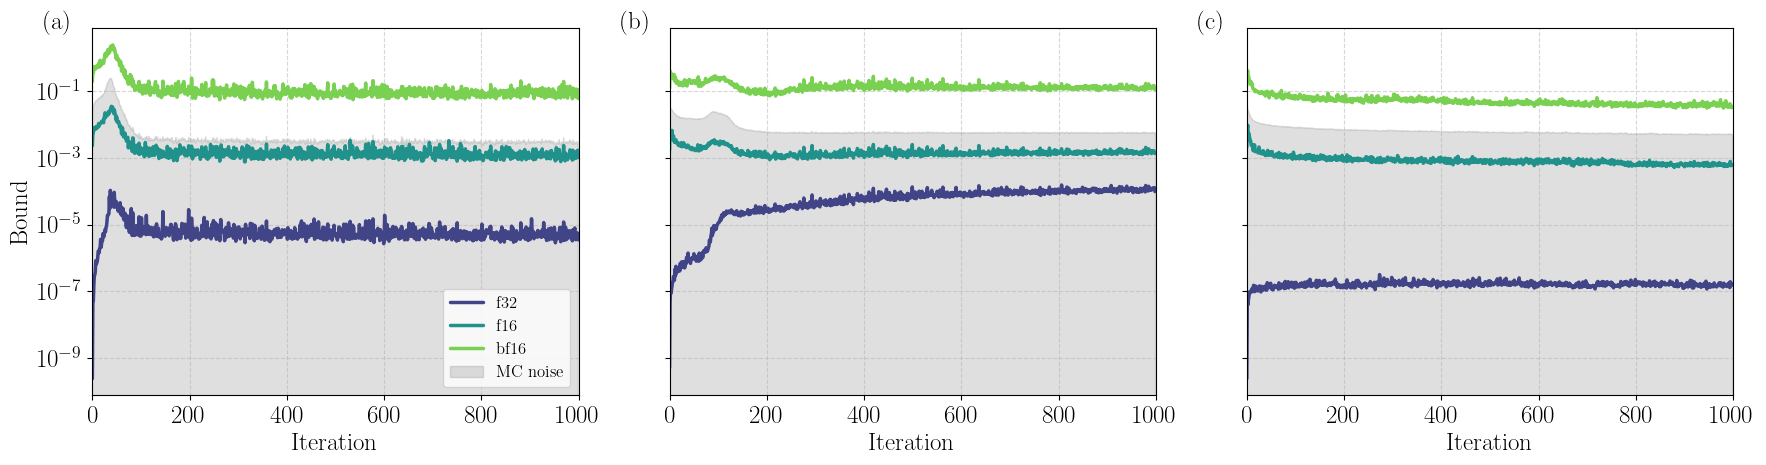

In [79]:
fig, axes = plt.subplots(1, len(hs), figsize=(18, 5), sharey=True)

dtype_labels_plot = ['f32', 'f16', 'bf16']
dtype_indices = [1, 2, 3]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(dtype_labels) - 1))

for i, (ax, h) in enumerate(zip(axes, hs)):
    ax.text(-0.1, 1.05, f'({chr(97+i)})', transform=ax.transAxes, fontweight='bold', va='top')
    for d_idx, (d, color) in enumerate(zip(dtype_indices, colors)):
        bound_data = min_bound(
            np.asarray(gradient_max[i]),
            np.asarray(sigma[i][d])
        )
        
        x = np.arange(len(bound_data))
        ax.plot(
            x,
            bound_data,
            color=color,
            lw=2.5,
            label=dtype_labels_plot[d_idx],
            dash_capstyle='round',
            solid_capstyle='round'
        )
        # ax.set_ylim(1e-10, 0.9)
    
    noise_data = gradient_noise[i] * np.sqrt(2) * 3
    x_noise = np.linspace(0, len(bound_data) - 1, len(noise_data))
    noise_interp = np.interp(x, x_noise, noise_data)
    ax.fill_between(
        x,
        0,
        noise_interp,
        color='gray',
        alpha=0.25,
        label='MC noise'
    )
    
    ax.set_xlim(0, len(bound_data))
    ax.set_yscale("log")
    ax.set_xlabel("Iteration")
    # ax.set_title(f"h = {h}")
    ax.grid(True, ls="--", alpha=0.5)
    if i ==0:
        ax.legend(loc="lower right")

axes[0].set_ylabel("Bound")

plt.tight_layout()
plt.savefig('figures/gradients_noise.pdf')
plt.show()